In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab09_FLC.ipynb")

# Lab 9: Regression, but modified for our FLC

Welcome to Lab 9!

Today we will get some hands-on practice with linear regression. You can find more information about this topic in
[Chapter 15.2](https://www.inferentialthinking.com/chapters/15/2/Regression_Line.html#the-regression-line).

**Submission**: Once you’re finished, run all cells besides the last one, select File > Save Notebook, and then execute the final cell. Then submit the downloaded zip file, that includes your notebook,  according to your instructor's directions.

**Editor's note:** This lab has been modified from the original Lab 9 notebook to adapt it for our FLC. It may not be perfect, but here goes!

In [2]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

import d8error

# Introduction to Linear Regression 

Before we get into the lab examples, it might be helpful for us to know a bit about linear regression first.

Linear regression is simply a way to model relationships between two or more variables. For two variables, we use a familiar equation:
$$y = mx+b$$
Here, $x$ represents an independent (predictor) variable and $y$ represents a depended (predicted) variable. For consistency with other materials, we will instead write:
$$y = \beta_0 + \beta_1 x$$
as our model. 

Our goal with regression is to find the **best** linear equation that fits our data. By **best**, we mean the line that is the **closest** to all data points, when compared to any other line.

## But wait, not all relationships are linear ... isn't this a bit simplistic?

How astute of you! It's true, not all relationships are linear.

However, many variables can be mathematically *transformed* so that the relationship can be modeled as linear. While we won't get into the details of such transformations here, this concept makes linear regression *impressively* powerful for a *huge* range of relationships between variables.

To illustrate this, let's run the following code. Please do not change anything in the cell below.


In [196]:
# Creating some random data to work with
rawDataX0 = np.arange(1,501,1)+np.random.choice(np.arange(2,500,0.01), 500)
rawDataY0 = (rawDataX0+np.random.choice(np.arange(-250,250,1), 500))**2
rawDataX = rawDataX0/50;
rawDataY = (rawDataY0-min(rawDataY0)+1)/10000

# Creating a data table
myData = Table().with_column("x",rawDataX)
myData = myData.with_column("y",rawDataY)
myData 

x,y
8.0736,19.1553
7.5438,9.13075
1.196,1.6424
3.625,8.89418
2.29,0.0001
7.785,9.50068
3.7898,18.1882
2.8062,2.38003
6.8598,25.5004
8.132,28.0465


Note that the data above contains x and y variables as pairs. Let's take a look at the data.

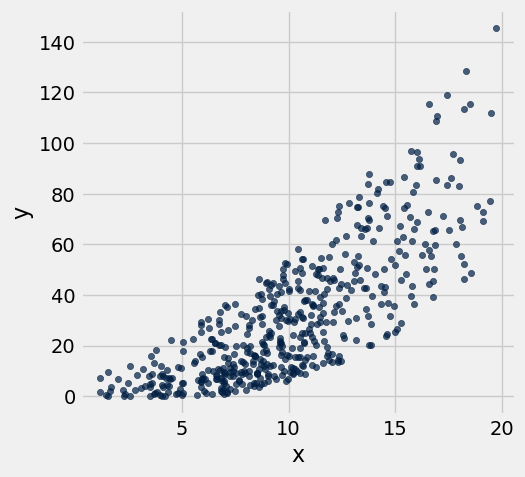

In [197]:
myData.scatter(0) 

This data certainly does not look linear right now, it appears to have some non-linear (i.e. curvy) relationship. 

Now we will *transform* the data mathematically. Running the code below *but do not change it*.

In [198]:
y_transformed = myData.column("y")**0.5
myData_transformed = Table().with_columns("x", myData.column("x"),"y", y_transformed)
myData_transformed

x,y
8.0736,4.37667
7.5438,3.02171
1.196,1.28156
3.625,2.98231
2.29,0.01
7.785,3.08232
3.7898,4.26477
2.8062,1.54274
6.8598,5.04979
8.132,5.29589


It is hard to tell what this transformation may have done to our data, so let's visualize our new data by running the code below.

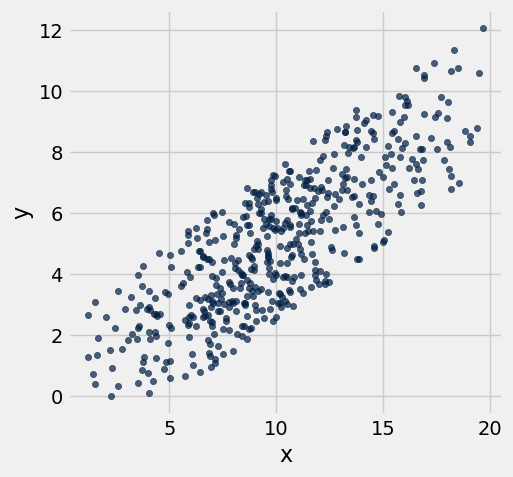

In [199]:
myData_transformed.scatter(0) 

Now the data appears linearly-related now and we could model this relationship with a model like $$y = \beta_0 + \beta_1 x.$$

# Concepts needed for Linear Regression

The general concepts needed for linear regression are:

   1. **Averages** (means) of $x$ and $y$. These are usually notated as $\bar{x}$ and $\bar{y}$. 
   2. **Standard deviations** of $x$ and $y$ (notated as $s_x$ and $s_y$). These give us an idea of the general *spread* of the data.
   3. **Correlation** between $x$ and $y$ (notated as $r$) this is a number between -1 and 1 that measures how much $x$ and $y$ are related. If they are perfectly related (i.e. no randomness in our linear data) and the slope of the relationship is *positive*, the correlation is 1. If they are perfectly related (i.e. no randomness in our linear data) and the slope of the relationship is *negative*, the correlation is -1. A correlation of 0 indicates no relationship.
   4. **Residuals** (usually notated as $e_i$). If we consider a data point $(x_i,y_i)$ in our data set, residuals can be thought of as the deviation of the *actual* $y$-value ($y_i$) from the *predicted* $y$ value from the regression line (i.e. $y(x_i) = \beta_0+\beta_1 x_i$). In other words, residuals are defined as: $$ e_i = y_i - y(x_i) = y_i - \beta_0-\beta_1 x_i$$
   
Let's find these measures for myData_transformed. Fill in the cell below.
   

In [200]:
# Find the average of x and y below:
mean_x = np.average(myData_transformed.column("x"))
mean_y = np.average(myData_transformed.column("y"))

print(mean_x, mean_y)


10.0903856 5.08790281895


Now let's find the standard deviations using np.std(array).

In [201]:
# Find the standard deviations of x and y below:
std_x = np.std(myData_transformed.column("x"))
std_y = np.std(myData_transformed.column("y"))

print(std_x, std_y)


3.99985897109 2.36301421436


Your averages should be around $(\bar{x},\bar{y})=(10,5)$ and your standard deviations should be around $(s_x,s_y)=(4,2.4)$. *Note that these estimates are not exact--our data set is randomly re-generated every time we run our code.*

Now let's find correlation using the concept of *standard units*. Standard (or normalized) units are defined as:
$$ x_{standard} = \frac{x -\bar{x}}{s_x}$$
$$ y_{standard} = \frac{y -\bar{y}}{s_y}$$
Importantly, this tranforms our variables to a standard frame of reference where the **means of $x_{standard}$ and $y_{standard}$ are 0** and the **standard deviations of $x_{standard}$ and $y_{standard}$ are 1**.

Fill in the code below to find the standardized $x$ and $y$ variables from myData_transformed:

In [202]:
x_standard = (myData_transformed.column("x")-mean_x)/std_x
y_standard = (myData_transformed.column("y")-mean_y)/std_y

Now we are ready to find correlation, which is found by **multiplying** $x_{standard}$ and $y_{standard}$ and then taking their average. Fill in the cell below:

In [203]:
r = np.mean(x_standard * y_standard)
r

0.8163758133804726

You answer should be around 0.8, which means the variables are fairly linearly related! This means using a linear regression model is warranted.


# How to find a Regression Line   
   
A regression line is a line $y = \beta_0+\beta_1 x$ that satisfies two major conditions:
   1. The line must go through the average $(x,y)$ point, which is $(\bar{x},\bar{y})$.
   2. The line must minimize residule values (i.e. fit the data the best).
Our task is to find $\beta_0$ (the y-intercept) and $\beta_1$ (the slope).
   
It turns out that the formulas for finding these are fairly simple. First, we find $\beta_1$ using this formula:
$$ \beta_1 = r\frac{s_y}{s_x}$$
Then, we find $\beta_0$ using:
$$ \beta_0 = \bar{y}-\beta_1 \bar{x}$$
This definition of $\beta_0$ enforces that the line goes through $(\bar{x},\bar{y})$. The combination of these two definitions for $\beta_0$ and $\beta_1$ minimize residule values.

Let's now find $\beta_0$ and $\beta_1$. Fill in the code below.

In [206]:
beta_1 = r*std_y/std_x
beta_0 = mean_y-beta_1*mean_x

# Plotting a regression line

For this, we need a new function to help us plot lines. Please run the code below *without changing it*.

In [208]:
def plot_data_and_line(dataset, x, y, point_0, point_1):
    """Makes a scatter plot of the dataset, along with a line passing through two points."""
    dataset.scatter(x, y, label="data")
    xs, ys = zip(point_0, point_1)
    plots.plot(xs, ys, label="regression line")
    plots.legend(bbox_to_anchor=(1.5,.8))

Recall our linear regression model is:
$$ y = \beta_0+\beta_1 x$$
To plot a line using this equation, we just need two $x$ values so we can compute two *predicted* $y$ values. This results in two points, which we will use to plot a line.

Let's suppose $x_1$ is the minumum $x$ value and $x_2$ is the maximum $x$value in myData_transformed. Fill in the code below to find the predicted $y$ values:

In [210]:
x1 = min(myData_transformed.column("x"))
x2 = max(myData_transformed.column("x"))
y1 = beta_0+beta_1*x1
y2 = beta_0+beta_1*x2

# Print out points on the line:
print(x1,y1)
print(x2,y2)

1.191 0.795783277553
19.697 9.72111450863


Now we will plot our regression line with myData_transformed:

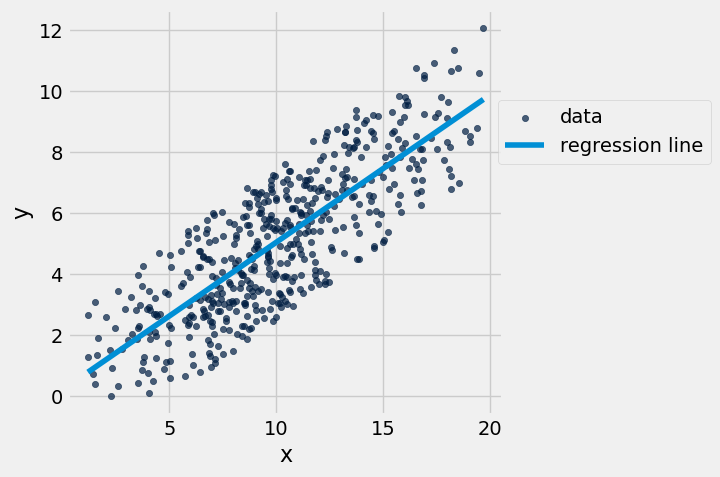

In [211]:
plot_data_and_line(myData_transformed, 
                   "x", 
                   "y", 
                   [x1, y1], 
                   [x2, y2])

Now we're ready to explore a real-world data set!

# 1. How Faithful is Old Faithful? 

Old Faithful is a geyser in Yellowstone National Park that is famous for eruption on a fairly regular schedule. Run the cell below to see Old Faithful in action!

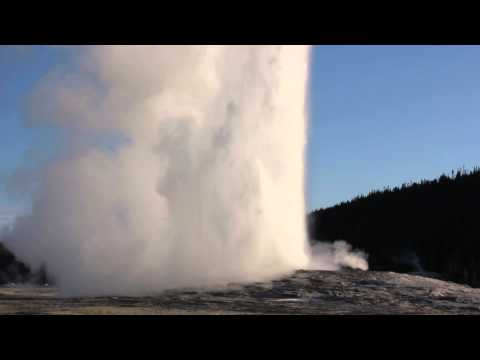

In [2]:
# For the curious: this is how to display a YouTube video in a
# Jupyter notebook.  The argument to YouTubeVideo is the part
# of the URL (called a "query parameter") that identifies the
# video.  For example, the full URL for this video is:
#   https://www.youtube.com/watch?v=wE8NDuzt8eg
from IPython.display import YouTubeVideo
YouTubeVideo("wE8NDuzt8eg")

Some of Old Faithful's eruptions last longer than others.  Whenever there is a long eruption, it is usually followed by an even longer wait before the next eruption. If you visit Yellowstone, you might want to predict when the next eruption will happen, so that you can see the rest of the park instead of waiting by the geyser.
 
Today, we will use a dataset on eruption durations and waiting times to see if we can make such predictions accurately with linear regression.

The dataset has one row for each observed eruption.  It includes the following columns:
- `duration`: Eruption duration, in minutes
- `wait`: Time between this eruption and the next, also in minutes

Run the next cell to load the dataset.

In [3]:
faithful = Table.read_table("faithful.csv")
faithful

duration,wait
3.6,79
1.8,54
3.333,74
2.283,62
4.533,85
2.883,55
4.7,88
3.6,85
1.95,51
4.35,85


**Question 1.0.** The following statements are the unordered steps of linear regression.  

1. Compute the parameters of the regression line: the slope and the intercept. 
2. Evaluate the regression line by computing the line’s RMSE and analyzing the residuals plot. 
3. Use the regression line to generate predictions for each x value. 
4. Determine if linear regression is a reasonable method by visualizing your data and computing the correlation coefficient. 

Make an array called `least_squares_order` that contains the correct order of a linear regression analysis, where the first item of the array is the first step of an linear regression analysis and the last item of the array is the last step of an linear regression analysis.


In [4]:
least_squares_order = make_array(4, 1, 3, 2) # SOLUTION

In [5]:
len(least_squares_order) == 4

True

In [6]:

import hashlib # This imports a hashing library for the autograder.
def get_hash(num):
    """Helper function for assessing correctness."""
    return hashlib.md5(str(num).encode()).hexdigest()

get_hash(np.array(least_squares_order).astype(int)) # Your ordering is incorrect.

'cd29f2d730e11535cef30ecc78640daa'

We would like to use linear regression to make predictions, but that won't work well if the data aren't roughly linearly related.  To check that, we should look at the data.

**Question 1.1.** Make a scatter plot of the data.  It's conventional to put the column we want to predict on the vertical axis and the other column on the horizontal axis.


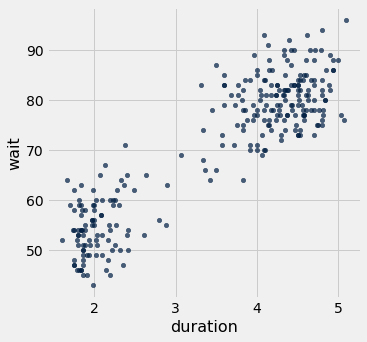

In [7]:
faithful.scatter("duration") #SOLUTION

**Question 1.2.** Are eruption duration and waiting time roughly linearly related based on the scatter plot above? Is this relationship positive?


**SOLUTION:** Yes, they are roughly linearly related.  The eruption durations seem to cluster; there are a bunch of short eruptions and a bunch of longer ones.  But the data in both clusters fall roughly on a line, and that's what's important when it comes to predicting waiting times with linear regression.  The relationship is positive, meaning that longer eruptions have longer waiting times, as we claimed.

We're going to continue with the assumption that they are linearly related, so it's reasonable to use linear regression to analyze this data.

We'd next like to plot the data in standard units. If you don't remember the definition of standard units, textbook section [14.2](https://www.inferentialthinking.com/chapters/14/2/Variability.html#standard-units) might help!

**Question 1.3.** Compute the mean and standard deviation of the eruption durations and waiting times.  **Then** create a table called `faithful_standard` containing the eruption durations and waiting times in standard units.  The columns should be named `duration (standard units)` and `wait (standard units)`.


In [8]:
# BEGIN SOLUTION NO PROMPT
duration_mean = np.mean(faithful.column("duration"))
duration_std = np.std(faithful.column("duration"))
wait_mean = np.mean(faithful.column("wait"))
wait_std = np.std(faithful.column("wait"))

faithful_standard = Table().with_columns(
    "duration (standard units)", (faithful.column("duration") - duration_mean) / duration_std,
    "wait (standard units)", (faithful.column("wait") - wait_mean) / wait_std)
faithful_standard
# END SOLUTION
""" # BEGIN PROMPT
duration_mean = ...
duration_std = ...
wait_mean = ...
wait_std = ...

faithful_standard = Table().with_columns(
    "duration (standard units)", ...,
    "wait (standard units)", ...)
faithful_standard
"""; # END PROMPT

In [9]:
abs(sum(faithful_standard.column(0))) <= 1e-8

True

In [10]:
round(duration_std, 2) == 1.14

True

In [11]:
round(wait_std, 2) == 13.57 

True

**Question 1.4.** Plot the data again, but this time in standard units.


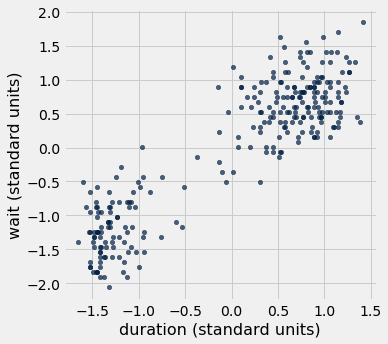

In [12]:
faithful_standard.scatter(0) #SOLUTION

You'll notice that this plot looks the same as the last one!  However, the data and axes are scaled differently.  So it's important to read the ticks on the axes.

**Question 1.5.** Among the following numbers, which would you guess is closest to the correlation between eruption duration and waiting time in this dataset?

1. -1
2. 0
3. 1

Assign `correlation` to the number corresponding to your guess (either 1, 2 or 3).


In [13]:
correlation = 3 # SOLUTION

In [14]:

import hashlib # This imports a hashing library for the autograder.
def get_hash(num):
    """Helper function for assessing correctness."""
    return hashlib.md5(str(num).encode()).hexdigest()

get_hash(int(correlation)) # Your choice is incorrect.

'eccbc87e4b5ce2fe28308fd9f2a7baf3'

**Question 1.6.** Compute the correlation coefficient: `r`.  

*Hint:* Use `faithful_standard`.  Section [15.1](https://www.inferentialthinking.com/chapters/15/1/Correlation.html#calculating-r) explains how to do this.



In [15]:
r = np.mean(faithful_standard.column(0) * faithful_standard.column(1)) #SOLUTION
r

0.9008111683218132

In [16]:
-1 <= r <= 1

True

In [17]:
round(r,3) == 0.901

True

## 2. The regression line
Recall that the **correlation** is the **slope of the regression line when the data are put in standard units**.

The next cell plots the regression line in standard units:

$$\text{waiting time in standard units} = r \times \text{eruption duration in standard units}$$

Then, it plots the data in standard units again, for comparison.

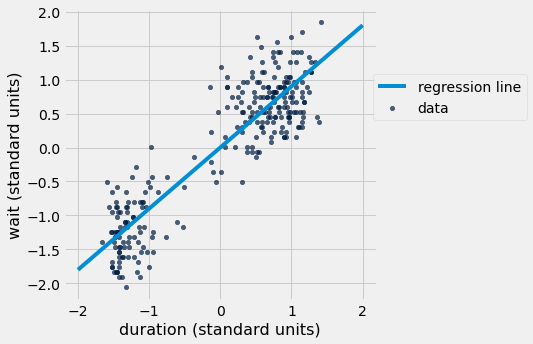

In [18]:
# Here is where the original Lab 09 defined the plotting function. 
# We do not need to redefine here, so have commented it out
# ----------------------------------------------------------------
#def plot_data_and_line(dataset, x, y, point_0, point_1):
#    """Makes a scatter plot of the dataset, along with a line passing through two points."""
#    dataset.scatter(x, y, label="data")
#    xs, ys = zip(point_0, point_1)
#    plots.plot(xs, ys, label="regression line")
#    plots.legend(bbox_to_anchor=(1.5,.8))

plot_data_and_line(faithful_standard, 
                   "duration (standard units)", 
                   "wait (standard units)", 
                   [-2, -2*r], 
                   [2, 2*r])

How would you take a point in standard units and convert it back to original units?  We'd have to "stretch" its horizontal position by `duration_std` and its vertical position by `wait_std`. That means the same thing would happen to the slope of the line.

Stretching a line horizontally makes it less steep, so we divide the slope by the stretching factor.  Stretching a line vertically makes it more steep, so we multiply the slope by the stretching factor.

**Question 2.1.** Calculate the slope of the regression line in original units, and assign it to `slope`.

(If the "stretching" explanation is unintuitive, consult section [15.2](https://www.inferentialthinking.com/chapters/15/2/Regression_Line.html#the-equation-of-the-regression-line) in the textbook.)


In [19]:
slope = (wait_std/duration_std) * r #SOLUTION
slope

10.729641395133527

In [20]:
(slope*13 - 100)/98 <= 0.5

True

In [21]:
np.round(slope, 4) == 10.7296 # Make sure you are plugging in the SD_x and SD_y in the correct spots!

True

We know that the regression line passes through the point `(duration_mean, wait_mean)`. Recall that the equation of the regression line in the original units is:

$$\text{waiting time} = \text{slope} \times \text{eruption duration} + (- \text{slope} \times \text{duration\_mean + wait\_mean})$$


**Question 2.2.** Calculate the intercept in original units and assign it to `intercept`. [Section 15.2.5](https://inferentialthinking.com/chapters/15/2/Regression_Line.html#the-regression-line-in-standard-units) may be helpful.


In [22]:
intercept = slope*(-duration_mean) + wait_mean #SOLUTION
intercept

33.47439702275335

In [23]:
33 < intercept < 34

True

In [24]:
np.round(intercept, 3) == 33.474

True

## 3. Investigating the regression line
The slope and intercept tell you exactly what the regression line looks like.  To predict the waiting time for an eruption, multiply the eruption's duration by `slope` and then add `intercept`.

**Question 3.1.** Compute the predicted waiting time for an eruption that lasts 2 minutes, and for an eruption that lasts 5 minutes.


In [25]:
two_minute_predicted_waiting_time = slope*2 + intercept #SOLUTION
five_minute_predicted_waiting_time = slope*5 + intercept #SOLUTION

# Here is a helper function to print out your predictions.
# Don't modify the code below.
def print_prediction(duration, predicted_waiting_time):
    print("After an eruption lasting", duration,
          "minutes, we predict you'll wait", predicted_waiting_time,
          "minutes until the next eruption.")

print_prediction(2, two_minute_predicted_waiting_time)
print_prediction(5, five_minute_predicted_waiting_time)

After an eruption lasting 2 minutes, we predict you'll wait 54.933679813020404 minutes until the next eruption.
After an eruption lasting 5 minutes, we predict you'll wait 87.12260399842098 minutes until the next eruption.


In [26]:
round(two_minute_predicted_waiting_time, 3) == 54.934

True

In [27]:
round(five_minute_predicted_waiting_time, 3) == 87.123

True

The next cell plots the line that goes between those two points, which is (a segment of) the regression line.

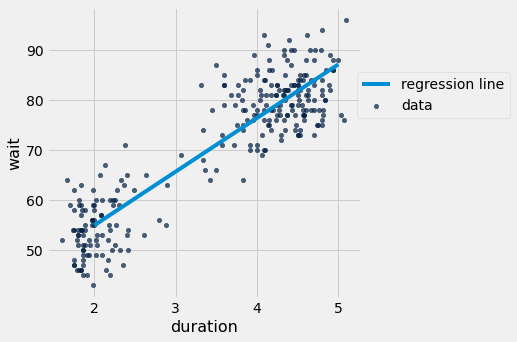

In [28]:
plot_data_and_line(faithful, "duration", "wait", 
                   [2, two_minute_predicted_waiting_time], 
                   [5, five_minute_predicted_waiting_time])

**Question 3.2.** Make predictions for the waiting time after each eruption in the `faithful` table.  (Of course, we know exactly what the waiting times were!  We are doing this so we can see how accurate our predictions are.)  Put these numbers into a column in a new table called `faithful_predictions`.  Its first row should look like this:

|duration|wait|predicted wait|
|-|-|-|
|3.6|79|72.1011|

*Hint:* Your answer can be just one line, though you are not limited to one line.  There is no need for a `for` loop; use array arithmetic instead.


In [29]:
faithful_predictions = faithful.with_column("predicted wait", slope*faithful.column("duration") + intercept) #SOLUTION
faithful_predictions

duration,wait,predicted wait
3.6,79,72.1011
1.8,54,52.7878
3.333,74,69.2363
2.283,62,57.9702
4.533,85,82.1119
2.883,55,64.408
4.7,88,83.9037
3.6,85,72.1011
1.95,51,54.3972
4.35,85,80.1483


In [30]:
set(faithful_predictions.labels) == set(['duration', 'wait', 'predicted wait']) # Make sure your column labels are correct.

True

In [31]:
abs(1 - np.mean(faithful_predictions.column(2))/100) <= 0.35

True

**Question 3.3.** How close were we?  Compute the *residual* for each eruption in the dataset.  The residual is the actual waiting time minus the predicted waiting time.  Add the residuals to `faithful_predictions` as a new column called `residual` and name the resulting table `faithful_residuals`.

*Hint:* Again, your code will be much simpler if you don't use a `for` loop.


In [32]:
faithful_residuals = faithful_predictions.with_column("residual", faithful_predictions.column(1) - faithful_predictions.column(2)) #SOLUTION
faithful_residuals

duration,wait,predicted wait,residual
3.6,79,72.1011,6.89889
1.8,54,52.7878,1.21225
3.333,74,69.2363,4.76371
2.283,62,57.9702,4.02983
4.533,85,82.1119,2.88814
2.883,55,64.408,-9.40795
4.7,88,83.9037,4.09629
3.6,85,72.1011,12.8989
1.95,51,54.3972,-3.3972
4.35,85,80.1483,4.85166


In [33]:
set(faithful_residuals.labels) == set(['duration', 'wait', 'predicted wait', 'residual']) # Make sure your column labels are correct.

True

In [34]:
abs(sum(faithful_residuals.column('residual'))) <= 1e-8

True

Here is a plot of the residuals you computed.  Each point corresponds to one eruption.  It shows how much our prediction over- or under-estimated the waiting time.

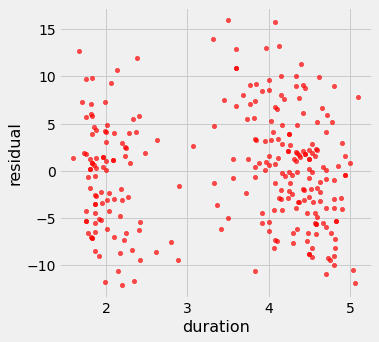

In [35]:
faithful_residuals.scatter("duration", "residual", color="r")

There isn't really a pattern in the residuals, which confirms that it was reasonable to try linear regression.  It's true that there are two separate clouds; the eruption durations seemed to fall into two distinct clusters.  But that's just a pattern in the eruption durations, not a pattern in the relationship between eruption durations and waiting times.

## 4. How accurate are different predictions?
Earlier, you should have found that the correlation is fairly close to 1, so the line fits fairly well on the training data.  That means the residuals are overall small (close to 0) in comparison to the waiting times.

We can see that visually by plotting the waiting times and residuals together:

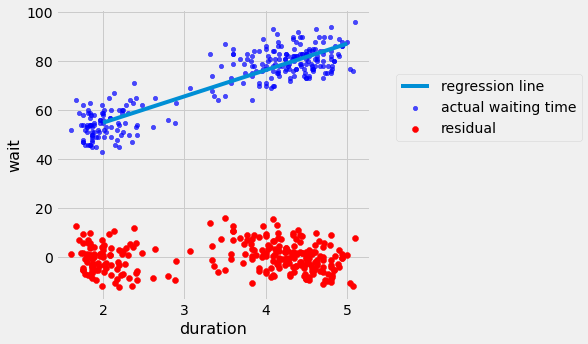

In [36]:
# Just run this cell.
faithful_residuals.scatter("duration", "wait", label="actual waiting time", color="blue")
plots.scatter(faithful_residuals.column("duration"), faithful_residuals.column("residual"), label="residual", color="r")
plots.plot([2, 5], [two_minute_predicted_waiting_time, five_minute_predicted_waiting_time], label="regression line")
plots.legend(bbox_to_anchor=(1.7,.8));

However, unless you have a strong reason to believe that the linear regression model is true, you should be wary of applying your prediction model to data that are very different from the training data.

**Question 4.1.** In `faithful`, no eruption lasted exactly 0, 2.5, or 60 minutes.  Using this line, what is the predicted waiting time for an eruption that lasts 0 minutes?  2.5 minutes?  An hour?


In [37]:
zero_minute_predicted_waiting_time = intercept #SOLUTION
two_point_five_minute_predicted_waiting_time = slope * 2.5 + intercept #SOLUTION
hour_predicted_waiting_time = slope * 60 + intercept #SOLUTION

print_prediction(0, zero_minute_predicted_waiting_time)
print_prediction(2.5, two_point_five_minute_predicted_waiting_time)
print_prediction(60, hour_predicted_waiting_time)

After an eruption lasting 0 minutes, we predict you'll wait 33.47439702275335 minutes until the next eruption.
After an eruption lasting 2.5 minutes, we predict you'll wait 60.29850051058717 minutes until the next eruption.
After an eruption lasting 60 minutes, we predict you'll wait 677.252880730765 minutes until the next eruption.


In [38]:
12 - zero_minute_predicted_waiting_time*1.4/4 <= 0.35

True

In [39]:
zero_minute_predicted_waiting_time - intercept <= 1e5

True

In [40]:
2 - two_point_five_minute_predicted_waiting_time/35 <= 0.4

True

In [41]:
(26 - hour_predicted_waiting_time/30)/10 <= 0.43

True

**Question 4.2.** For each prediction, state whether you think it's reliable and explain your reasoning. 


**SOLUTION:** The prediction for 2.5 is believable, since the dataset has eruptions that are *around* that long.  A 0 minute eruption is physically impossible, so the predicted waiting time is meaningless.  A 60 minute eruption might be possible, but since we never saw one nearly that long, it would probably be very different in character than the ones in `faithful`.  So we probably shouldn't trust that prediction, either.

## 5. Divide and Conquer

It appears from the scatter diagram that there are two clusters of points: one for durations around 2 and another for durations between 3.5 and 5. A vertical line at 3 divides the two clusters.

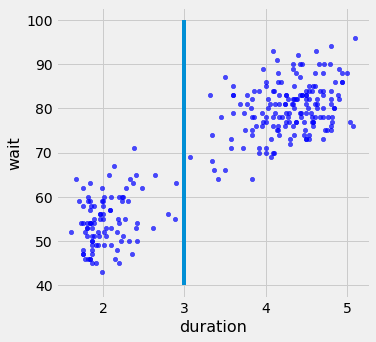

In [42]:
faithful.scatter("duration", "wait", label="actual waiting time", color="blue")
plots.plot([3, 3], [40, 100]);

The `standardize` function from lecture appears below, which takes in a table with numerical columns and returns the same table with each column converted into standard units.

In [43]:
# Just run this cell.

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

**Question 5.1.** Separately compute the correlation coefficient *r* for all the points with a duration below 3 **and then** for all the points with a duration above 3. To do so, create a function that computes `r` from a table, and then pass it two different tables of points, called `below_3` and `above_3`.

*Hint:* You can assume that the table does not have any duration values that are exactly 3. 


In [44]:
def corr_coeff(t):
    """Return the regression coefficient for columns 0 & 1."""
    t_su = standardize(t)
    return np.mean(t_su.column(0) * t_su.column(1)) # SOLUTION

below_3 = faithful.where('duration', are.below(3)) # SOLUTION
above_3 = faithful.where('duration', are.above(3)) # SOLUTION
below_3_r = corr_coeff(below_3)
above_3_r = corr_coeff(above_3)
print("For points below 3, r is", below_3_r, "; for points above 3, r is", above_3_r)

For points below 3, r is 0.2901895264925431 ; for points above 3, r is 0.3727822255707511


In [45]:
[below_3.num_rows, above_3.num_rows]

[97, 175]

In [46]:
np.allclose([below_3_r, above_3_r], [0.290189526493, 0.372782225571])

True

**Question 5.2.** Complete the functions `slope_of` and `intercept_of` below. 

When you're done, the functions `wait_below_3` and `wait_above_3` should each use a different regression line to predict a wait time for a duration. The first function should use the regression line for all points with duration below 3. The second function should use the regression line for all points with duration above 3.


In [47]:
def slope_of(table, r):
    """Return the slope of the regression line for table in original units.
    
    Assume that column 0 contains x values and column 1 contains y values.
    r is the regression coefficient for x and y.
    """
    return r * np.std(table.column(1)) / np.std(table.column(0)) # SOLUTION

def intercept_of(table, r):
    """Return the intercept of the regression line for table in original units."""
    slope = slope_of(table, r)
    return slope * (-np.mean(table.column(0))) + np.mean(table.column(1)) # SOLUTION
    
below_3_slope = slope_of(below_3, below_3_r)
below_3_intercept = intercept_of(below_3, below_3_r)
above_3_slope = slope_of(above_3, above_3_r)
above_3_intercept = intercept_of(above_3, above_3_r)

def wait_below_3(duration):
    return below_3_slope * duration + below_3_intercept

def wait_above_3(duration):
    return above_3_slope * duration + above_3_intercept

In [48]:
np.allclose([wait_below_3(1), wait_below_3(3), wait_above_3(3), wait_above_3(6)], 
            [47.902151605742517, 60.603197182023813, 72.965413990538366, 89.281859197449506])

True

The plot below shows the two different regression lines, one for each cluster, along with the original regression line!

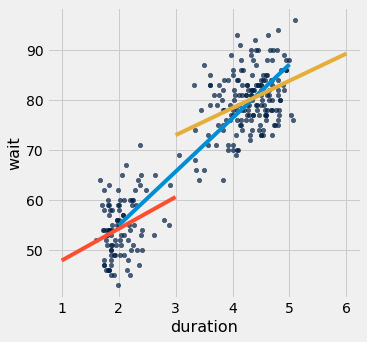

In [49]:
faithful.scatter(0, 1)
plots.plot([2, 5], [two_minute_predicted_waiting_time, five_minute_predicted_waiting_time])
plots.plot([1, 3], [wait_below_3(1), wait_below_3(3)])
plots.plot([3, 6], [wait_above_3(3), wait_above_3(6)]);

**Question 5.3.** Write a function `predict_wait` that takes a `duration` and returns the predicted wait time using the appropriate regression line, depending on whether the duration is below 3 or greater than (or equal to) 3.


In [50]:
# BEGIN SOLUTION NO PROMPT
def predict_wait(duration):
    if duration < 3:
        return wait_below_3(duration)
    else:
        return wait_above_3(duration)
# END SOLUTION
""" # BEGIN PROMPT
def predict_wait(duration):
    ...
"""; # END PROMPT 

In [51]:
np.allclose([predict_wait(x) for x in [1.5, 2.5]], 
            [51.077412999812836, 57.427935787953487])

True

In [52]:
np.allclose([predict_wait(x) for x in [3.5, 4.5]], 
            [75.684821525023551, 81.123636593993922])

True

The predicted wait times for each point appear below.

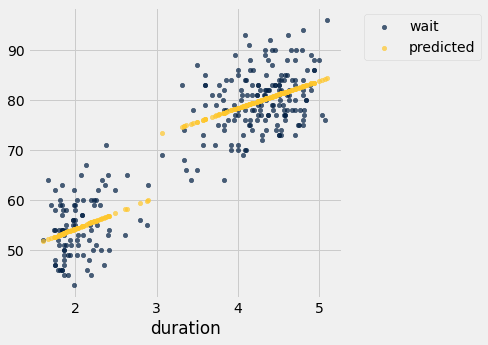

In [53]:
faithful_pred_split = faithful.with_column('predicted', faithful.apply(predict_wait, 'duration'))
faithful_pred_split.scatter(0)

**Question 5.4.** Do you think the predictions produced by `predict_wait` would be more or less accurate than the predictions from the regression line you created in section 2? How could you tell?

**SOLUTION:** More accurate, because each line is specific to the values in its cluster. To verify, we could measure the average magnitude of the residual values.

The following cell will plot the residuals for each eruption in the dataset when we have one regression line and two regression lines. We also see the average magnitude of the residual values.

Average Magnitude of Residual Values for One Regression Line:  4.778720058765493
Average Magnitude of Residual Values for Two Regression Lines:  4.57575882719415


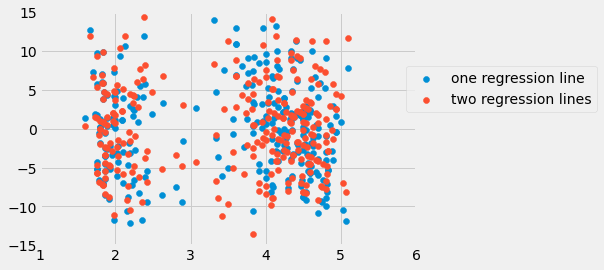

In [54]:
# Just run this cell
faithful_pred_split_residuals = faithful_pred_split.with_column('residual', faithful_pred_split.column(1) - faithful_pred_split.column(2))
plots.scatter(faithful_residuals.column('duration'), faithful_residuals.column('residual'), label='one regression line')
plots.scatter(faithful_pred_split_residuals.column('duration'), faithful_pred_split_residuals.column('residual'), label='two regression lines');
plots.axis([1, 6, -15, 15])
plots.legend(bbox_to_anchor=(1.5,.8));
print("Average Magnitude of Residual Values for One Regression Line: ", np.mean(abs(faithful_residuals.column('residual'))))
print("Average Magnitude of Residual Values for Two Regression Lines: ", np.mean(abs(faithful_pred_split_residuals.column('residual'))))

The residual plot for the wait times when they are predicted by two regression lines (red) doesn't really have a pattern, which confirms that it was also appropriate to use linear regression in our "Divide and Conquer" scenario. How do the two residual plots compare?

## 6. Submission

<img src="lab09_pets.jpg" alt="drawing" width="500"/>

Congratulations, you're done with Lab 9!

**Important submission steps:** 
1. Run the tests and verify that they all pass.
2. Choose **Save Notebook** from the **File** menu, then **run the final cell**. 
3. Click the link to download the zip file.
4. Then submit the zip file to the corresponding assignment according to your instructor's directions. 

**It is your responsibility to make sure your work is saved before running the last cell.**